<a href="https://colab.research.google.com/github/Bryan-Az/ClusteringMethod-Slate/blob/main/DBScan_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Clustering by DBScan
In this notebook I will be running clustering on the emotional speech audio dataset using the DBScan clustering algorithm. 
1. DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a popular clustering algorithm used in machine learning and data analysis.
2. I will be using the same data as was used to cluster using the Gaussian Mixture Model (this model was able to cluster high dimensional data and was able to cluster more complex data than K-Means).
3. The difference between K-Means and Gaussian Mixture (gmm) models is that GMM were able to capture non-circular shaped clusters.
4. An expected difference between GMM and DBScan is that DBScan doesn't require to be told the number of clusters beforehand for tuning. 

In this notebook, I want to assess the difference in how the DBScan clusters perform as compared to the same set of data as was processed in the GMM notebook.

## Data Loading

In [2]:
actors_meta_df = pd.read_csv('./data_samples/actors_meta_df.csv', on_bad_lines='skip')

In [3]:
actors_meta_df.columns

Index(['actor', 'tempo', 'y', 'sr', 'onset_env', 'spectral_centroid',
       'spectral_bandwidth', 'spectral_rolloff', 'zero_crossing_rate',
       'chroma_stft', 'mfcc', 'rmse', 'modality', 'vocal_channel', 'emotion',
       'emotional_intensity', 'statement', 'repetition'],
      dtype='object')

In [9]:
numerical_df = actors_meta_df.loc[:, ['tempo', 'modality', 'vocal_channel', 'emotion',
       'emotional_intensity', 'statement', 'repetition']]

In [10]:
numerical_df.head()

,tempo,modality,vocal_channel,emotion,emotional_intensity,statement,repetition
0,83.354335,3,1,1,1,2,2
1,71.777344,3,1,2,1,2,1
2,99.384014,3,1,2,2,1,1
3,161.499023,3,1,3,1,1,2
4,51.679688,3,1,3,2,2,2


## Data Pre-Processing

In [11]:
# applying the standard scaler to the numerical data
scaler = StandardScaler()
scaler.fit(numerical_df)
scaled_df = scaler.transform(numerical_df)
scaled_df = pd.DataFrame(scaled_df, columns=numerical_df.columns)

In [13]:
scaled_df_interpretable = scaled_df.loc[:, ['tempo', 'emotion', 'emotional_intensity', 'statement', 'repetition']]
scaled_df_interpretable.head()

,tempo,emotion,emotional_intensity,statement,repetition
0,-1.016677,-1.716790,-0.935414,1.0,1.0
1,-1.295054,-1.256936,-0.935414,1.0,-1.0
2,-0.631232,-1.256936,1.069045,-1.0,-1.0
3,0.862367,-0.797081,-0.935414,-1.0,1.0
4,-1.778317,-0.797081,1.069045,1.0,1.0


## Exploratory Data Analysis & Visualization

A main difference between the proposed benefits of choosing DBSCAN as opposed to other clustering methods is that it can:
1. Take into account clusters having many kinds of non-circular shapes
2. That it doesn't need to be told the number of clusters beforehand
This is a key difference as the Gaussian Mixture model (for a better clustering) needed to be told the init_means (proposed cluster centers), the number of clusters, as well as the type of covariance_type (whether the clusters were similar in shape or not).

In [14]:
# applying PCA to the scaled data
pca = PCA(n_components=2)
pca.fit(scaled_df_interpretable)
pca_df = pca.transform(scaled_df_interpretable)
pca_df = pd.DataFrame(pca_df, columns=['PC1', 'PC2'])
pca_df.head()

,PC1,PC2
0,1.929035,-0.409483
1,1.646587,-1.482976
2,0.149863,-0.083424
3,1.149331,1.357508
4,-0.093402,-0.930054


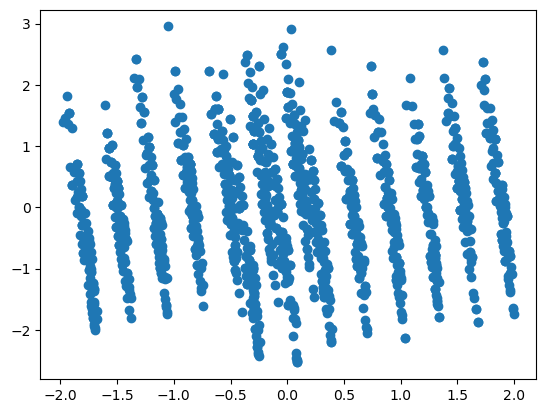

In [15]:
# plotting the pca
plt.scatter(pca_df['PC1'], pca_df['PC2'])

## Clustering

In [138]:
def cluster_and_evaluate(eps, min_samples, data):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(data)
    
    # Filtering out noise for cluster size evaluation
    clusters = labels[labels != -1]
    unique, counts = np.unique(clusters, return_counts=True)
    # Calculate percentage of each class
    class_percentages = counts / len(data)
    
    # Check if a majority of each class takes at least 8% of all datapoints and less than 15% and has more than 5 classes
    percent_check_majority = [True if (x > 0.08) and (x < 0.40) else False for x in class_percentages]
    if (len(unique) > 5) and ((sum(percent_check_majority)/len(percent_check_majority))> 0.3):
        best_metric = 0
    else:
        # Set best metric to infinity if classes do not meet the percentage requirement
        best_metric = float('inf')
    
    return unique, best_metric, labels, class_percentages


Best Params: {'eps': 0.26, 'min_samples': 16}
Best Cluster Balance Metric: 0
Best Class Percentages: [0.50416667 0.14375    0.02708333 0.0875     0.02083333 0.01319444]
Number of Classes: 6


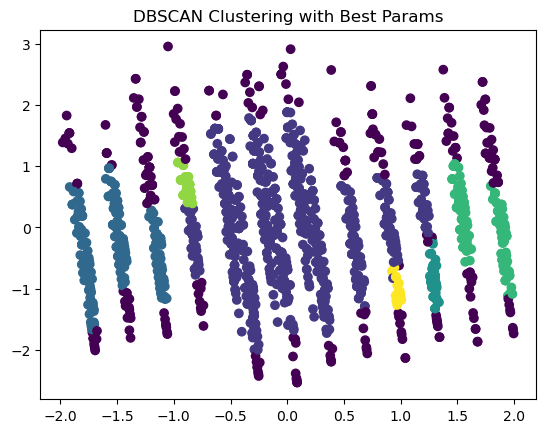

In [140]:
# Define ranges for eps and min_samples
eps_values = np.arange(0.01, 2.0, 0.01)  # Example range, adjust as needed
min_samples_values = range(2, 20)  # Example range, adjust as needed

best_metric = float('inf')
best_params = {}
best_labels = None
best_class_percentages = None
# Grid search
for eps in eps_values:
    for min_samples in min_samples_values:
        _, metric, labels, class_percentages = cluster_and_evaluate(eps, min_samples, pca_df)
        
        if metric < best_metric:
            best_metric = metric
            best_params = {'eps': eps, 'min_samples': min_samples}
            best_labels = labels
            best_class_percentages = class_percentages

# Output best parameters and metric
print("Best Params:", best_params)
print("Best Cluster Balance Metric:", best_metric)
print("Best Class Percentages:", best_class_percentages)
print("Number of Classes:", len(best_class_percentages))

# Optional: Visualize the best clustering result
# This is applicable if your data is 2D or can be effectively visualized in 2D
plt.scatter(pca_df.iloc[:, 0], pca_df.iloc[:, 1], c=best_labels, cmap='viridis', marker='o')
plt.title('DBSCAN Clustering with Best Params')
plt.show()

## Assessing the Clusters
A key difference between DBScan and GMM methods from Sklearn is that the GMM method creates a generative model that is able to learn the underlying distribution of the data - whereas the DBSCAN model is purely a clustering model. 

DBSCAN learns the clusters' based on their density within the dataset, and therefore is not able to be told explicitly what the cluster centers 'should' be or look like.

Therefore, GMM was easier to fine-tune and create clusters that look appropriate by visualizing the PCA plot and selecting the cluster centers by eye. 

DBSCAN on the other hand, is less able to be guided using input of cluster centers and so it was necessary to use grid search to find the best hyper-parameters. For example, the eps and the min_samples parameters. 

eps: The maximum distance between two samples for them to be considered in the same neighborhood.
min_samples: The number of samples in a neighborhood for a point to be considered a core point.

**Overall Conclusion**

I was not able to achieve similar clusters as in the Gaussian MM notebook as hyper-parameter tuning and much experimentation using grid search (or other search methods) and the best criteria is needed. It could be that the clusters in this PCA for this specific dataset is not the best and might be difficult for the DBScan model to identify.